In [5]:
import numpy as np
import tensorflow as tf
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import re

def remove_whitespaces(string):
    return ''.join(string.split())


def parse_rtttl(rtttl_str, strict_note_syntax=False):
    rtttl_parts = rtttl_str.split(':')

    if len(rtttl_parts) != 3:
        raise ValueError('RTTTL string should contain title, defaults and data part, separated by colon')

    if len(rtttl_parts[2]) == 0:
        raise ValueError('Data part cannot be empty')


    defaults = parse_defaults(remove_whitespaces(rtttl_parts[1]))
    # print(defaults)
    parsed_notes = parse_data(remove_whitespaces(rtttl_parts[2]).lower(), strict_note_syntax)
    # print(parsed_notes)

    for parsed_note in parsed_notes:
        # keys = ('duration', 'pitch', 'octave', 'dot')
        # print('parsed_note ', parsed_note, 'with default: ', defaults)
        for key, value in parsed_note.items():
            if value is None:
                if key == 'duration':
                    parsed_note[key] = defaults['duration']
                elif key == 'octave':
                    parsed_note[key] = defaults['octave']
                elif key == 'bpm':
                    parsed_note[key] = defaults['bpm']
                else:
                    raise ValueError('Error key')

    return {'title': rtttl_parts[0], 'notes': parsed_notes}


def parse_defaults(defaults_str):
    if defaults_str == '':
        return {'duration': 4, 'octave': 6, 'bpm': 63}

    try:
        if re.match(r'^(d=\d{1,2},o=\d,b=\d{1,3})?$', defaults_str):
            defaults = dict([d.split('=') for d in defaults_str.split(',')])
            parsed_defaults = {
                'duration': parse_duration(defaults['d']),
                'octave': parse_octave(defaults['o']),
                'bpm': parse_bpm(defaults['b'])
                }
        else:
            raise ValueError('Invalid defaults section format')
    except ValueError as element:
        raise ValueError('%s in %s' % (element.message, defaults_str))

    return parsed_defaults


def parse_data(notes, strict_note_syntax):
    raw_notes = notes.split(',')
    # print(raw_notes)

    if not strict_note_syntax:
        raw_notes = [correct_note_syntax(note) for note in raw_notes]

    # print(raw_notes)
    return [parse_note(note) for note in raw_notes]


def correct_note_syntax(note):
    return re.sub(r'^(\d{0,2})([pbeh]|[cdfga]#?)(\.?)(\d*)$', r'\1\2\4\3', note)


def parse_note(note_str):
    try:
        elements = re.findall(r'^(\d{0,2})([pbeh]|[cdfga]#?)(\d?)(\.?)$', note_str)[0]
        # print(elements)
        # return
        funcs = (parse_duration, parse_pitch, parse_octave, has_dot)
        elements = [func(element) for func, element in zip(funcs, elements)]
    except ValueError as element:
        raise ValueError(' %s in note %s' % (element.message, note_str))
    except IndexError:
        raise ValueError('Invalid note: %s' % note_str)
    keys = ('duration', 'pitch', 'octave', 'dot')
    return dict(zip(keys, elements))


def parse_duration(duration):
    allowed_duration = [1, 2, 4, 8, 16, 32]
    return parse_int(duration, allowed_duration)


def parse_octave(octave):
    allowed_octave = [4, 5, 6, 7]
    return parse_int(octave, allowed_octave)


def parse_bpm(bpm):
    allowed_bpm = [
        25, 28, 31, 35, 40, 45, 50, 56, 63, 70, 80, 83, 90,
        100, 112, 120, 125, 140, 160, 180, 200, 225, 250, 285,
        320, 355, 400, 450, 500, 565, 635, 715, 800, 900]
    return parse_int(bpm, allowed_bpm)


def parse_pitch(pitch):
    allowed_pitch = ['p', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'h', 'b']
    return parse_element(pitch, allowed_pitch)


def parse_int(element, allowed):
    if element:
        return parse_element(int(element), allowed)
    return None


def parse_element(element, allowed):
    if element in allowed:
        return element
    else:
        raise ValueError('Element \'%s\' is not allowed' % element)


def has_dot(dot):
    return dot == '.'

In [7]:
#parse("112 - Peaches And Cream : d=4,o=5,b=100:8b6,16p,8b.6,8g6,8e6,b6,8p,8b6,16p,8b.6,8g6,8d7,b6,8p,8b,16p,8b.,8f#6,8g6,a6,8p,8b,16p,8b.,8f#6,8g6,8a6,8f#6,8g6,8b6,16p,8b.6,8g6,8e6,b6,8p,8b6,16p,8b.6,8g6,8d7,b6,")

In [8]:
import pandas as pd

In [26]:
import os

path_to_data = 'rtttl2'

notes = []
durations = []
octaves = []
dots = []

result = []
i = 0
for file_name in os.listdir(path_to_data):
    if file_name.endswith('.txt'):
        file_path = os.path.join(path_to_data, file_name)

        with open(file_path, 'r', encoding = 'ISO-8859-1') as file_:
            print(file_path)
            lines = file_.readlines()
            try:
                for line in lines:
                    # print(line)
                    if line is None:
                        continue

                    if line.strip() == '':
                        continue

                    line = line.strip()
                    line = line.strip(',')
                    tunes = parse_rtttl(line.strip())
                    for tune in tunes['notes']:

                        duration = tune['duration']
                        note_str = tune['pitch'].lower()  # normalize to lowercase
                        # note = note_to_int[note_str]
                        # note = note_str
                        is_dotted = 1 if tune['dot'] else 0
                        octave = tune['octave']
                        notes.append(note_str)
                        durations.append(duration)
                        octaves.append(octave)
                        dots.append(is_dotted)

                        result.append((duration, note_str, octave, is_dotted))
            except ValueError as e:
                print(file_path)
                print(e)

rtttl2\112 - Its Over Now .txt
rtttl2\112 - Peaches And Cream .txt
rtttl2\187 Lockdown - Kung Fu .txt
rtttl2\2Pac - All Eyez On Me .txt
rtttl2\2Pac - California Love .txt
rtttl2\2Pac - Changes .txt
rtttl2\2Pac - Dear Mama .txt
rtttl2\2Pac - Hit Em Up .txt
rtttl2\2Pac - I Aint Mad At Cha .txt
rtttl2\2Pac - Two Of Amerikas Most Wanted .txt
rtttl2\3 Doors Down - Kryptonite (Chorus .txt
rtttl2\3 Doors Down - Kryptonite .txt
rtttl2\633 Squadron Theme .txt
rtttl2\A Team Theme .txt
rtttl2\A1 - Everytime .txt
rtttl2\A1 - Like A Rose .txt
rtttl2\A1 - Same Old Brand New You .txt
rtttl2\A1 - Take On Me .txt
rtttl2\Aaliyah - Try Again .txt
rtttl2\Aaron Soul - Ring Ring Ring .txt
rtttl2\Abba - Mamma Mia .txt
rtttl2\Abba - Money Money Money .txt
rtttl2\Adam Sandler - Grow Old With You .txt
rtttl2\Adams Family .txt
rtttl2\Adams Family Theme .txt
rtttl2\Aerosmith - Dont Wanna Miss A Thing .txt
rtttl2\Airwolf Theme .txt
rtttl2\Alice Deejay - Better Off Alone .txt
rtttl2\Alice Deejay - I Want You Back I

In [27]:
note_names = sorted(set([note for note in notes]))
n_diff_notes = len(set(notes))

duration_names = sorted(set([duration for duration in durations]))
n_diff_durations = len(set(durations))

octave_names = sorted(set([octave for octave in octaves]))
n_diff_octaves = len(set(octaves))

dot_names = sorted(set([dot for dot in dots]))
n_diff_dots = len(set(dots))

In [28]:
note_names

['a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'p']

In [29]:
duration_names

[1, 2, 4, 8, 16, 32]

In [30]:
octave_names

[5, 6, 7]

In [31]:
note_to_int = {}
index = 1
for note_name in note_names:
    if note_name not in note_to_int:
        note_to_int[note_name] = index
        index += 1
        
duration_to_int = {}
index = 1
for duration_name in duration_names:
    if duration_name not in duration_to_int:
        duration_to_int[duration_name] = index
        index += 1
        
octave_to_int = {}
index = 1
for octave_name in octave_names:
    if octave_name not in octave_to_int:
        octave_to_int[octave_name] = index
        index += 1
        
dot_to_int = {}
index = 1
for dot_name in dot_names:
    if dot_name not in dot_to_int:
        dot_to_int[dot_name] = index
        index += 1

In [32]:
int_to_note = {index: note_name for note_name, index in note_to_int.items()}
int_to_duration = {index: duration_name for duration_name, index in duration_to_int.items()}
int_to_octave = {index: octave_name for octave_name, index in octave_to_int.items()}
int_to_dot = {index: dot_name for dot_name, index in dot_to_int.items()}

In [33]:
note_to_int

{'a': 1,
 'a#': 2,
 'b': 3,
 'c': 4,
 'c#': 5,
 'd': 6,
 'd#': 7,
 'e': 8,
 'f': 9,
 'f#': 10,
 'g': 11,
 'g#': 12,
 'p': 13}

In [34]:
def encode_input(sequence):
    encoded_sequence = []

    for duration, note, octave, dot in sequence:
        # One-hot encode duration using predefined allowed durations
        duration_one_hot = np.zeros(len(duration_names))
        duration_index = duration_names.index(duration)
        duration_one_hot[duration_index] = 1

        # One-hot encode note (13 possible values)
        note_one_hot = np.zeros(len(note_names))
        note_index = note_names.index(note)
        note_one_hot[note_index] = 1

        # One-hot encode octave using predefined allowed octaves
        octave_one_hot = np.zeros(len(octave_names))
        octave_index = octave_names.index(octave)
        octave_one_hot[octave_index] = 1

        # Encode dot (0 or 1)
        encoded_dot = np.array([dot])

        # Concatenate the one-hot vectors and dot into a single encoded vector
        encoded_vector = np.concatenate([duration_one_hot, note_one_hot, octave_one_hot, encoded_dot])

        encoded_sequence.append(encoded_vector)
    
    return np.array(encoded_sequence)

In [35]:
from tqdm import tqdm

In [47]:
sequenceLength = 50

networkInput = []
networkOutput = []
n = len(result)


for i in tqdm(range(0, n - sequenceLength)):
    sequenceIn = result[i : i + sequenceLength ] 
    sequenceOut = result[ i + sequenceLength]  
    
    networkInput.append(encode_input(sequenceIn))
    networkOutput.append(encode_input([sequenceOut]))

100%|████████████████████████████████████████████████████████████████████████████| 8275/8275 [00:02<00:00, 3752.84it/s]


In [48]:
networkInput = np.array(networkInput)
networkOutput = np.array(networkOutput)

In [49]:
networkOutput = np.squeeze(networkOutput, axis=1) # fix 

In [50]:
networkInput.shape

(8275, 50, 23)

In [51]:
networkOutput.shape

(8275, 23)

In [52]:
nPatterns = len(networkInput)


In [53]:
nPatterns

8275

In [54]:
result[0]

(8, 'c', 6, 0)

In [55]:
networkInput[0][0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [56]:
result[50]

(8, 'b', 6, 1)

In [57]:
networkOutput[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

In [58]:
networkInput.shape

(8275, 50, 23)

In [57]:
networkOutput.shape

(8276, 23)

In [242]:
# input is encoded propertly.

In [30]:
import logging
logging.basicConfig(filename='elmanrr.log', format='%(levelname)s:%(message)s', filemode='w', level=logging.DEBUG)
logger = logging.getLogger()
# logging.debug('This message should go to the log file1 2 3 ')

In [31]:
# https://en.wikipedia.org/wiki/Backpropagation_through_time  Backpropagation through time (BPTT) is a gradient-based technique for training certain types of recurrent neural networks. It can be used to train Elman networks. The algorithm was independently derived by numerous researchers.

In [116]:
import tensorflow as tf
from tqdm import tqdm

logger.disabled = True

class ElmanRNN(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_layer = tf.keras.layers.Dense(hidden_size, activation='tanh')
        self.hidden_layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.output_layer = tf.keras.layers.Dense(output_size)

    def call(self, inputs, initial_state):
        sequence_length = inputs.shape[1]
        # logger.debug(f'sequence_length {sequence_length}')
        outputs = []
        hidden_state = initial_state 
        # logger.debug(f'hidden_state {hidden_state.shape}')
        for t in range(sequence_length):
            x_t = inputs[:, t, :] # Get the current input at time t 
            # logger.debug(f'x_t shape {x_t.shape}') 
            combined = tf.concat([x_t, hidden_state], axis=1) 
            # logger.debug(f'combined_shape: {combined.shape}')
            hidden_state = self.hidden_layer(combined)
            hidden_state = self.hidden_layer2(hidden_state)
            # logger.debug(f'hidden_state shape: {hidden_state.shape}')
            # output = self.output_layer(hidden_state)
            # logger.debug(f'output shape  {output.shape}')
            # outputs.append(output)
            # logger.debug('\n')
        output = self.output_layer(hidden_state)
        return output, hidden_state

In [117]:
logger.disabled = False

In [118]:
logger.disabled = True

In [119]:
networkInput.shape

(8275, 50, 23)

In [120]:
hidden_size = 256
output_size = networkInput.shape[2]
# input_dim = 24
learning_rate = 0.001
# input_size = 24
epochs = 100

In [121]:
train_dataset = tf.data.Dataset.from_tensor_slices(networkInput).batch(64)
labels = tf.data.Dataset.from_tensor_slices(networkOutput).batch(64)

In [122]:
model = ElmanRNN(hidden_size, output_size)

In [123]:
def split_and_calculate_loss2(target, out):
    # Split the tensors
    target_splits = tf.split(target, [6, 13, 3, 1], axis=-1)
    out_splits = tf.split(out, [6, 13, 3, 1], axis=-1)
    
    # Calculate loss for each split
    loss_splits = []
    for i, (t, o) in enumerate(zip(target_splits, out_splits)):
        if i == 3:  # The last split with size 1
            loss = tf.keras.losses.binary_crossentropy(t, o, from_logits=True)
        else:
            loss = tf.keras.losses.categorical_crossentropy(t, o, from_logits=True)
            
        # loss = tf.reduce_mean(loss, axis=-1)
        loss_splits.append(loss)
    
    # Combine the losses 
    combined_loss = tf.reduce_mean(tf.stack(loss_splits, axis=-1))
    
    return combined_loss

In [124]:
def split_and_calculate_loss(target, out):
    # Idea is to split tensor in format that was first introdused, and then apply loss on parts of tensor
    # So i split it in 6, 13, 3, 1

    # Split the tensors
    target_splits = tf.split(target, [6, 13, 3, 1], axis=-1)
    out_splits = tf.split(out, [6, 13, 3, 1], axis=-1)
    
    # Calculate loss for each split
    loss_splits = []
    for i, (t, o) in enumerate(zip(target_splits, out_splits)):
        # labels = tf.cast(tf.squeeze(t, axis=-1), dtype=tf.float32)
        # logits = tf.cast(tf.squeeze(o, axis=-1), dtype=tf.float32)
        if i == 3:  # The last split with size 1
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(tf.squeeze(t, axis=-1), dtype=tf.float32), logits=tf.cast(tf.squeeze(o, axis=-1), dtype=tf.float32))
        else:
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=o)  # should i use softmax with logits here ? 
        loss_splits.append(loss)
    
    # Combine the losses, use mean
    combined_loss = tf.reduce_mean(tf.stack(loss_splits, axis=-1))
    
    return combined_loss

In [241]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [126]:
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    logger.debug(f"Epoch {epoch}/{epochs}")
    with tqdm(total=len(train_dataset), desc="Loss", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} ") as pbar:
        for batch, label in zip(train_dataset, labels):
            initial_hidden_state = tf.zeros((batch.shape[0], hidden_size))
            # print(initial_hidden_state)
            with tf.GradientTape() as tape:
                output, _ = model(batch, initial_hidden_state)
                
                # targets = batch[:, 1:, :] 
                # outs = outputs[:, :-1, :]
                # print(targets.shape)
                # print(outs.shape)
                
                loss = split_and_calculate_loss(label, output)
                # print(loss)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            pbar.set_description(f"Loss: {loss:.6f}")
            pbar.update(1)

Epoch 1/100


Loss: 1.026706: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 2/100


Loss: 0.957193: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 3/100


Loss: 0.916524: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 4/100


Loss: 0.917292: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 5/100


Loss: 0.905014: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 6/100


Loss: 0.848744: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 7/100


Loss: 0.819350: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 8/100


Loss: 0.753037: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 9/100


Loss: 0.739159: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 10/100


Loss: 0.696891: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 11/100


Loss: 0.719288: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 12/100


Loss: 0.676162: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 13/100


Loss: 0.631427: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 14/100


Loss: 0.615383: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 15/100


Loss: 0.579719: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 16/100


Loss: 0.575082: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 17/100


Loss: 0.618445: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 18/100


Loss: 0.542891: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 19/100


Loss: 0.549414: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 20/100


Loss: 0.532645: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 21/100


Loss: 0.517737: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 22/100


Loss: 0.456203: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 23/100


Loss: 0.491958: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 24/100


Loss: 0.472759: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 25/100


Loss: 0.340135: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 26/100


Loss: 0.397200: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 27/100


Loss: 0.377800: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 28/100


Loss: 0.313441: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 29/100


Loss: 0.365700: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 30/100


Loss: 0.446793: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 31/100


Loss: 0.282132: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 32/100


Loss: 0.322709: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 33/100


Loss: 0.222651: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 34/100


Loss: 0.226806: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 35/100


Loss: 0.322866: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 36/100


Loss: 0.240220: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 37/100


Loss: 0.205337: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 38/100


Loss: 0.231934: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 39/100


Loss: 0.206349: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 40/100


Loss: 0.165332: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 41/100


Loss: 0.150824: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 42/100


Loss: 0.205703: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 43/100


Loss: 0.142318: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 44/100


Loss: 0.141001: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 45/100


Loss: 0.214431: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 46/100


Loss: 0.136776: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 47/100


Loss: 0.121067: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 48/100


Loss: 0.133222: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 49/100


Loss: 0.099057: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 50/100


Loss: 0.114208: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 51/100


Loss: 0.134284: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 52/100


Loss: 0.111713: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 53/100


Loss: 0.096929: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 54/100


Loss: 0.079634: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 55/100


Loss: 0.091695: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 56/100


Loss: 0.103896: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 57/100


Loss: 0.102442: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 58/100


Loss: 0.145228: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 59/100


Loss: 0.112267: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 60/100


Loss: 0.062722: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 61/100


Loss: 0.136690: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 62/100


Loss: 0.114771: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 63/100


Loss: 0.111806: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 64/100


Loss: 0.066224: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 65/100


Loss: 0.072662: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 66/100


Loss: 0.111814: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 67/100


Loss: 0.109936: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 68/100


Loss: 0.070477: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 69/100


Loss: 0.046624: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 70/100


Loss: 0.103822: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 71/100


Loss: 0.066396: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 72/100


Loss: 0.062623: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 73/100


Loss: 0.118771: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 74/100


Loss: 0.080582: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 75/100


Loss: 0.056545: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 76/100


Loss: 0.088489: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 77/100


Loss: 0.151470: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 78/100


Loss: 0.149914: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 79/100


Loss: 0.076129: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 80/100


Loss: 0.051521: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 81/100


Loss: 0.091379: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 82/100


Loss: 0.053104: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 83/100


Loss: 0.037915: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 84/100


Loss: 0.043292: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 85/100


Loss: 0.027947: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 86/100


Loss: 0.029685: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 87/100


Loss: 0.056794: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 88/100


Loss: 0.023771: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 89/100


Loss: 0.053115: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 90/100


Loss: 0.050112: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 91/100


Loss: 0.181624: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 92/100


Loss: 0.309914: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 93/100


Loss: 0.373957: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 94/100


Loss: 0.453946: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 95/100


Loss: 0.424567: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 96/100


Loss: 0.196906: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 97/100


Loss: 0.139296: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 98/100


Loss: 0.036000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 99/100


Loss: 0.048205: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


Epoch 100/100


Loss: 0.036446: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 


In [ ]:
history = model.fit(networkInput, networkOutput, epochs=100, batch_size=32, validation_split=0.2)

In [112]:
model.save('best_model', save_format='tf')

INFO:tensorflow:Assets written to: best_model\assets


In [2]:
from matplotlib import pyplot as plt

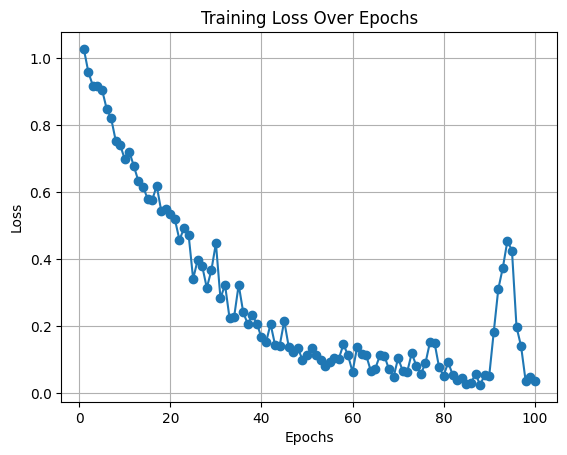

In [3]:
loss_values = [
    1.026706, 0.957193, 0.916524, 0.917292, 0.905014,
    0.848744, 0.819350, 0.753037, 0.739159, 0.696891,
    0.719288, 0.676162, 0.631427, 0.615383, 0.579719,
    0.575082, 0.618445, 0.542891, 0.549414, 0.532645,
    0.517737, 0.456203, 0.491958, 0.472759, 0.340135,
    0.397200, 0.377800, 0.313441, 0.365700, 0.446793,
    0.282132, 0.322709, 0.222651, 0.226806, 0.322866,
    0.240220, 0.205337, 0.231934, 0.206349, 0.165332,
    0.150824, 0.205703, 0.142318, 0.141001, 0.214431,
    0.136776, 0.121067, 0.133222, 0.099057, 0.114208,
    0.134284, 0.111713, 0.096929, 0.079634, 0.091695,
    0.103896, 0.102442, 0.145228, 0.112267, 0.062722,
    0.136690, 0.114771, 0.111806, 0.066224, 0.072662,
    0.111814, 0.109936, 0.070477, 0.046624, 0.103822,
    0.066396, 0.062623, 0.118771, 0.080582, 0.056545,
    0.088489, 0.151470, 0.149914, 0.076129, 0.051521,
    0.091379, 0.053104, 0.037915, 0.043292, 0.027947,
    0.029685, 0.056794, 0.023771, 0.053115, 0.050112,
    0.181624, 0.309914, 0.373957, 0.453946, 0.424567,
    0.196906, 0.139296, 0.036000, 0.048205, 0.036446
]

epochs = list(range(1, len(loss_values) + 1))

# Create the loss plot
plt.plot(epochs, loss_values, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# predicted_notes

In [ ]:
logger.disabled = False

In [59]:
def decode_output_tf(encoded_dataset):
    decoded_dataset = []
    for encoded_sequence in tqdm(encoded_dataset):
        decoded_sequence = []
        
        for encoded_vector in encoded_sequence:
            duration_onehot = encoded_vector[:6]
            note_onehot = encoded_vector[6:19]
            octave_onehot = encoded_vector[19:22]
            dot_onehot = [encoded_vector[22]]
            
            duration = tf.argmax(duration_onehot).numpy()
            note = tf.argmax(note_onehot).numpy()
            octave = tf.argmax(octave_onehot).numpy()
            dot = tf.argmax(dot_onehot).numpy()
            
             # indexing 1
            decoded_sequence.append((duration + 1, note + 1, octave + 1, dot + 1))
            
        decoded_dataset.append(decoded_sequence)
    return np.array(decoded_dataset)

In [202]:
def convert_indices_to_values(decoded_dataset):
    converted_dataset = []

    for decoded_sequence in decoded_dataset:
        converted_sequence = []

        for duration_idx, note_idx, octave_idx, dot_idx in decoded_sequence:
            duration = int_to_duration[duration_idx]
            note = int_to_note[note_idx]
            octave = int_to_octave[octave_idx]
            is_dot = int_to_dot[dot_idx]
            
            converted_sequence.append((duration, note, octave, is_dot))

        converted_dataset.append(converted_sequence)

    return np.array(converted_dataset)

In [23]:
import random

In [24]:
random.seed(2023)

In [ ]:
class MelodyGenerator:
    def __init__(self, population_size, num_generations, mutation_rate, crossover_rate, elitism_rate, target_fitness):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.target_fitness = target_fitness
        self.population = []

        self.octaves = octave_names.copy()
        self.durations = duration_names.copy()
        self.notes = note_names.copy()
        self.dots = [0, 1]
        
        self.hidden_size = 256
        
    def create_gene(self):
        duration = random.choice(self.durations)
        note = random.choice(self.notes)
        octave = random.choice(self.octaves)
        dot = random.choice(self.dots)
        
        encoded_gene = encode_input([(duration, note, octave, dot)])[0]
        return encoded_gene

    def create_chromosome(self, length):
        return [self.create_gene() for _ in range(length)]

    
    def fitness_function2(self, chromosome):
        final_fitness = 0
        initial_hidden_state = tf.zeros((len(chromosome), self.hidden_size))    
        notes = [tf.convert_to_tensor([note]) for note in chromosome]
        inputs = np.array(notes)
        
        outputs, _ = model(inputs, initial_hidden_state, training=False)
        final_fitness = 0

        for i in range(len(chromosome) - 1):
            output_note = chromosome[i + 1]
            fitness_pair = np.abs(outputs[i, :] - output_note)
            final_fitness += np.sum(fitness_pair)

        return np.sum(final_fitness)
    

    def initialize_population(self, length):
        self.population = [self.create_chromosome(length) for _ in range(self.population_size)]

    def roulette_wheel_selection(self, fitness_scores):
        selected_indices = []
        total_fitness = sum(fitness_scores)
        for _ in range(self.population_size):
            rand_val = random.uniform(0, total_fitness)
            cumulative_fitness = 0
            for i in range(self.population_size):
                cumulative_fitness += fitness_scores[i]
                if cumulative_fitness > rand_val:
                    selected_indices.append(i)
                    break
        return selected_indices

    def swap_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        idx1, idx2 = random.sample(range(len(chromosome)), 2)
        mutated_chromosome[idx1], mutated_chromosome[idx2] = mutated_chromosome[idx2], mutated_chromosome[idx1]
        return mutated_chromosome

    def scramble_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        start, end = sorted(random.sample(range(len(chromosome)), 2))
        genes_to_shuffle = mutated_chromosome[start:end]
        random.shuffle(genes_to_shuffle)
        mutated_chromosome[start:end] = genes_to_shuffle
        return mutated_chromosome

    def inversion_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        start, end = sorted(random.sample(range(len(chromosome)), 2))
        mutated_chromosome[start:end] = reversed(mutated_chromosome[start:end])
        return mutated_chromosome

    def replace_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        idx = random.randint(0, len(chromosome) - 1)
        mutated_chromosome[idx] = self.create_gene()
        return mutated_chromosome

    def one_point_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            crossover_point = random.randint(1, len(parent1) - 1)
            child = parent1[:crossover_point] + parent2[crossover_point:]
        else:
            child = random.choice([parent1, parent2])
        return child

    def two_point_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            start, end = sorted(random.sample(range(len(parent1)), 2))
            child = parent1[:start] + parent2[start:end] + parent1[end:]
        else:
            child = random.choice([parent1, parent2])
        return child

    def uniform_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            child = [random.choice([parent1[i], parent2[i]]) for i in range(len(parent1))]
        else:
            child = random.choice([parent1, parent2])
        return child

    def evolve(self, length):
        self.initialize_population(length)
        
        for generation in tqdm(range(self.num_generations)):
            fitness_scores = [self.fitness_function2(chromosome) for chromosome in self.population]
            # return
            #print(fitness_scores)
            
            best_fit_index = fitness_scores.index(min(fitness_scores))
            if fitness_scores[best_fit_index] < self.target_fitness:
                best_melody = self.population[best_fit_index]
                print(f"Found a fit melody in generation {generation}: {best_melody}")
                break

            selected_indices = self.roulette_wheel_selection(fitness_scores)

            new_population = []
            while len(new_population) < self.population_size:
                parent1_idx, parent2_idx = random.sample(selected_indices, 2)
                parent1, parent2 = self.population[parent1_idx], self.population[parent2_idx]

                child = self.one_point_crossover(parent1, parent2)

                if random.random() < self.mutation_rate:
                    mutation_operator = random.choice([self.swap_mutation, self.scramble_mutation, self.inversion_mutation, self.replace_mutation])
                    child = mutation_operator(child)

                new_population.append(child)

            num_elites = int(self.elitism_rate * self.population_size)
            elites = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:num_elites]
            new_population[:num_elites] = [self.population[i] for i in elites]

            self.population = new_population


generator = MelodyGenerator(
    population_size=50,
    num_generations=5000,
    mutation_rate=0.1,
    crossover_rate=0.7,
    elitism_rate=0.05,
    target_fitness=0.03
)


generator.evolve(length=50)

In [79]:
class GA_MusicRules:
    def __init__(self, population_size, num_generations, mutation_rate, crossover_rate, elitism_rate, target_fitness):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.target_fitness = target_fitness
        self.population = []

        self.octaves = [5, 6, 7, 8]
        self.durations = duration_names.copy()
        self.notes = note_names.copy()
        self.dots = [0, 1]
        
        self.scale = ['c', 'c', 'e', 'f', 'g', 'a', 'b']
        self.max_step = 2
        self.max_leap = 4
        self.proportion_notes_rests = 1.5
        self.max_repeating_notes = 2
        self.global_pitch_margin = 12
        
        self.hidden_size = 256
        self.best_melody = None
        self.best_fitness = None
        
    def create_gene(self):
        duration = random.choice(self.durations)
        note = random.choice(self.notes)
        octave = random.choice(self.octaves)
        dot = random.choice(self.dots)
        
        # encoded_gene = encode_input([(duration, note, octave, dot)])[0]
        return (duration, note, octave, dot)

    def create_chromosome(self, length):
        return [self.create_gene() for _ in range(length)]
    
    def fitness_function(self, chromosome):
        # Check adherence to musical rules and calculate fitness
        fitness = 0.0
        
        # Scale Rule
        # scale_notes = self.scale.split()
        for gene in chromosome:
            if gene[1] not in self.scale:
                fitness += 1.0  # Penalize notes outside the scale
        
        # Adjacent Notes Rule
        for i in range(1, len(chromosome)):
            note1 = self.notes.index(chromosome[i-1][1])
            note2 = self.notes.index(chromosome[i][1])
            diff = abs(note1 - note2)  # how to calculate this ? 
            if diff > self.max_step:
                fitness += 1.0  # Penalize large steps
            if diff > self.max_leap:
                fitness += 1.0  # Penalize large leaps
        
        # Proportion between Rests and Notes
        num_notes = sum(1 for gene in chromosome if gene[1] != 'p')
        num_rests = len(chromosome) - num_notes
        proportion = num_notes / (num_notes + num_rests)
        if proportion < self.proportion_notes_rests:
            fitness += 1.0  # Penalize melodies with too many rests
        
        # Repeating Notes Rule
        repetitions = 1
        for i in range(1, len(chromosome)):
            if chromosome[i] == chromosome[i-1]:
                repetitions += 1
            else:
                repetitions = 1
            if repetitions > self.max_repeating_notes:
                fitness += 1.0  # Penalize repeating notes
        
        # Global Pitch Distribution Rule
        pitches = [self.notes.index(gene[1]) + 12 * gene[2] for gene in chromosome]
        min_pitch = min(pitches)
        max_pitch = max(pitches)
        pitch_range = max_pitch - min_pitch
        if pitch_range > self.global_pitch_margin:
            fitness += 1.0  # Penalize melodies with a large pitch range
        
        return fitness

    def initialize_population(self, length):
        self.population = [self.create_chromosome(length) for _ in range(self.population_size)]

    def roulette_wheel_selection(self, fitness_scores):
        selected_indices = []
        total_fitness = sum(fitness_scores)
        for _ in range(self.population_size):
            rand_val = random.uniform(0, total_fitness)
            cumulative_fitness = 0
            for i in range(self.population_size):
                cumulative_fitness += fitness_scores[i]
                if cumulative_fitness > rand_val:
                    selected_indices.append(i)
                    break
        return selected_indices

    def swap_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        idx1, idx2 = random.sample(range(len(chromosome)), 2)
        mutated_chromosome[idx1], mutated_chromosome[idx2] = mutated_chromosome[idx2], mutated_chromosome[idx1]
        return mutated_chromosome

    def scramble_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        start, end = sorted(random.sample(range(len(chromosome)), 2))
        genes_to_shuffle = mutated_chromosome[start:end]
        random.shuffle(genes_to_shuffle)
        mutated_chromosome[start:end] = genes_to_shuffle
        return mutated_chromosome

    def inversion_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        start, end = sorted(random.sample(range(len(chromosome)), 2))
        mutated_chromosome[start:end] = reversed(mutated_chromosome[start:end])
        return mutated_chromosome

    def replace_mutation(self, chromosome):
        mutated_chromosome = chromosome[:]
        idx = random.randint(0, len(chromosome) - 1)
        mutated_chromosome[idx] = self.create_gene()
        return mutated_chromosome

    def one_point_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            crossover_point = random.randint(1, len(parent1) - 1)
            child = parent1[:crossover_point] + parent2[crossover_point:]
        else:
            child = random.choice([parent1, parent2])
        return child

    def two_point_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            start, end = sorted(random.sample(range(len(parent1)), 2))
            child = parent1[:start] + parent2[start:end] + parent1[end:]
        else:
            child = random.choice([parent1, parent2])
        return child

    def uniform_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            child = [random.choice([parent1[i], parent2[i]]) for i in range(len(parent1))]
        else:
            child = random.choice([parent1, parent2])
        return child

    def evolve(self, length):
        self.initialize_population(length)
        
        # print(self.population)
        for generation in tqdm(range(self.num_generations)):
            fitness_scores = [self.fitness_function(chromosome) for chromosome in self.population]
            
            # print(fitness_scores)
            # return
            #print(fitness_scores)
            
            best_fit_index = fitness_scores.index(min(fitness_scores))
            # print(best_fit_index)
            if fitness_scores[best_fit_index] < self.target_fitness:
                self.best_melody = self.population[best_fit_index]
                self.best_fitness = fitness_scores[best_fit_index]
                print(f"Found a fit melody in generation {generation}: {best_melody}")
                break

            selected_indices = self.roulette_wheel_selection(fitness_scores)

            new_population = []
            while len(new_population) < self.population_size:
                parent1_idx, parent2_idx = random.sample(selected_indices, 2)
                parent1, parent2 = self.population[parent1_idx], self.population[parent2_idx]

                child = self.one_point_crossover(parent1, parent2)

                if random.random() < self.mutation_rate:
                    mutation_operator = random.choice([self.swap_mutation, self.scramble_mutation, self.inversion_mutation, self.replace_mutation])
                    child = mutation_operator(child)

                new_population.append(child)

            num_elites = int(self.elitism_rate * self.population_size)
            elites = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:num_elites]
            new_population[:num_elites] = [self.population[i] for i in elites]

            self.population = new_population
        
        return self.best_melody, self.best_fitness

    

population_size = 100
num_generations = 300000
length = 50
GA_MusicRules_generator = GA_MusicRules(
    population_size=population_size,
    num_generations=num_generations,
    mutation_rate=0.1,
    crossover_rate=0.7,
    elitism_rate=0.05,
    target_fitness=0.2
)


GA_MusicRules_generator.evolve(length=length)

  0%|                                                                            | 284/300000 [00:01<34:26, 145.04it/s]


KeyboardInterrupt: 

In [ ]:
[GA_MusicRules_generator.fitness_function(pop) for pop in GA_MusicRules_generator.population]

In [152]:
import pickle

In [154]:
file_path = 'generator.population.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Serialize and save the list to the file
    pickle.dump(generator.population, file)

In [155]:
with open(file_path, 'rb') as file:
    # Deserialize and load the list from the file
    loaded_population = pickle.load(file)

In [267]:
decoded_population = decode_output_tf(generator.population)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 125.31it/s]


In [268]:
converted_population = convert_indices_to_values(decoded_population)

In [ ]:
!pip3 install --user scamp

In [75]:
from scamp import test_run; test_run.play()

In [77]:
import mido
from mido import MidiFile, MidiTrack, Message
from tqdm import tqdm
from scamp import *
from collections import namedtuple

def note_to_number(note, octave):
    note_mapping = {'p': 0, 'c': 1, 'c#': 2, 'd': 3, 'd#': 4, 'e': 5, 'f': 6, 'f#': 7, 'g': 8, 'g#': 9, 'a': 10, 'a#': 11, 'b': 12}

    # Calculate the MIDI note number based on note name and octave
    note_number = note_mapping.get(note, None)
    if note_number is not None:
        note_number += octave * 12  # Octave adjustment, maybe i should change this constant 12 to like octave_multiplier thats given in parser ? 

    return note_number


def note_tuple_to_midi(note_list, default_bpm, ticks_per_beat=120):
    duration, note, octave, dot = note_list
    duration = int(duration)
    octave = int(octave) #
    dot = int(dot)
    
    if note == 'p':
        # Skip generating MIDI messages for pauses
        return []

    
    # Calculate note duration with dots
    duration_ms = (4000 / duration) * (1 + 0.5 * dot)

    # Convert note to MIDI note number
    note_number = note_to_number(note, octave)
    # print(note_number)
    
    # Calculate MIDI ticks for the note duration
    tick_duration_ms = int(1.0 * 60000 / (default_bpm * ticks_per_beat))
    

    return [note_number, tick_duration_ms]

def note_list_to_midi_track(note_list, default_bpm, ticks_per_beat=120):
    track = MidiTrack()
    time_offset = 0 
    
    for i, note_list in enumerate(note_list):
        midi_messages = note_tuple_to_midi(note_list, default_bpm, ticks_per_beat)
        # print(midi_messages)
        # if i == 10:
        #    break
            
        if midi_messages:
            note_number, ticks = midi_messages
            # set time_offset
            track.append(Message('note_on', note=note_number, velocity=64, time=time_offset))
            track.append(Message('note_off', note=note_number, velocity=64, time=time_offset + ticks))
            # update time_offset based on ticks
            time_offset += ticks
    return track

# Define a function to create a MIDI file from a list of note lists
def create_midi_file(note_lists, default_bpm, output_filename):
    midi = MidiFile()
    
    for note_list in note_lists:
        track = note_list_to_midi_track(note_list, default_bpm)
        midi.tracks.append(track)
    
    # print(midi.length)
    midi.save(output_filename)

    
# #     allowed_bpm = [
#         25, 28, 31, 35, 40, 45, 50, 56, 63, 70, 80, 90,
#         100, 112, 125, 140, 160, 180, 200, 225, 250, 285,
#         320, 355, 400, 450, 500, 565, 635, 715, 800, 900]
# Example usage with a default BPM of 140

default_bpm = 100
output_file = f'song - {default_bpm}_{population_size}_{length}_{num_generations}.mid'
create_midi_file(GA_MusicRules_generator.population, default_bpm, output_file)